In [1]:
from keras.datasets import cifar10
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

Using TensorFlow backend.


In [2]:
eps = 0.007
max_n = 100

In [3]:
num_classes = 10

In [4]:
def predict(x, model):
    pred = model.predict(np.array([x]), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [5]:
def generate_p(x, label, model):
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([np.array([x])])
    
    p = np.sign(grads_val)
    
    return p.reshape(32,32,3)

In [6]:
def generate_adv(x, label, model, eps):
    p = generate_p(x, label, model)
    adv = (x - eps*p).clip(min=0, max=1)
    
    return adv

In [7]:
def generate_adv_list(x_list, y_list, model, eps):
    adv_list = []
    
    for x, y in zip(x_list, y_list):
        adv = generate_adv(x, y, model, eps)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [8]:
# データの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 正規化
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

y_train_catego = to_categorical(y_train, num_classes)
y_test_catego = to_categorical(y_test, num_classes)

In [9]:
# モデルを読み込む
model = model_from_json(open('10_model.json').read())

# 学習結果を読み込む
model.load_weights('10_weights.h5')

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

print(model.summary())

W0108 17:33:33.460011 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0108 17:33:33.478980 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0108 17:33:33.512616 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0108 17:33:33.516029 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0108 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [10]:
score = model.evaluate(x_test, y_test_catego, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.6479467062950134
Test accuracy : 0.7745


In [11]:
label =['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'track']

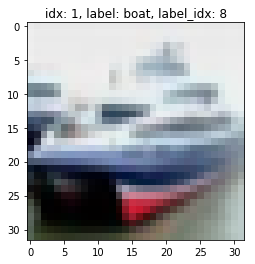

In [12]:
idx = 1
x = x_test[idx]
y = int(y_test[idx])

plt.imshow(x)
plt.title(f'idx: {idx}, label: {label[y]}, label_idx: {y}')
plt.show()

In [13]:
pred_class, pred_per = predict(x, model)
print(pred_class, pred_per)

8 0.93400156


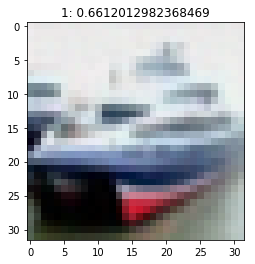

In [14]:
adv = generate_adv(x, y, model, eps)

pred_class, pred_per = predict(adv, model)

plt.imshow(adv)
plt.title(f'{pred_class}: {pred_per}')
plt.show()

In [15]:
adv_test = generate_adv_list(x_test[:max_n], y_test[:max_n], model, eps)
adv_test.shape

(100, 32, 32, 3)

In [16]:
score = model.evaluate(adv_test, y_test_catego[:max_n], verbose=0)
print('adv')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv
Test loss : 1.5385649633407592
Test accuracy : 0.53


In [17]:
score = model.evaluate(x_test[:max_n], y_test_catego[:max_n], verbose=0)
print('x')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

x
Test loss : 0.6361640274524689
Test accuracy : 0.79


adv
p: pred_class, t: true_class


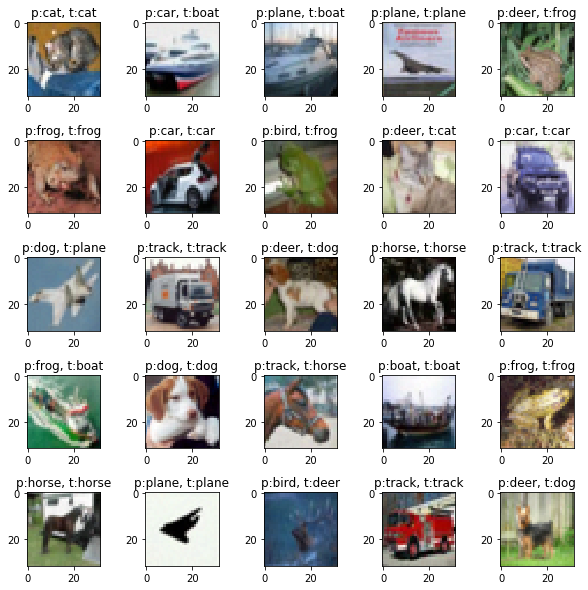

In [18]:
print('adv')
print('p: pred_class, t: true_class')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = adv_test[i]
    pred_class, pred_per = predict(img, model)
    plt.imshow(img)
    plt.title('p:{0}, t:{1}'.format(label[pred_class],label[int(y_test[i])]))

plt.show()

x
p: pred_class, t: true_class


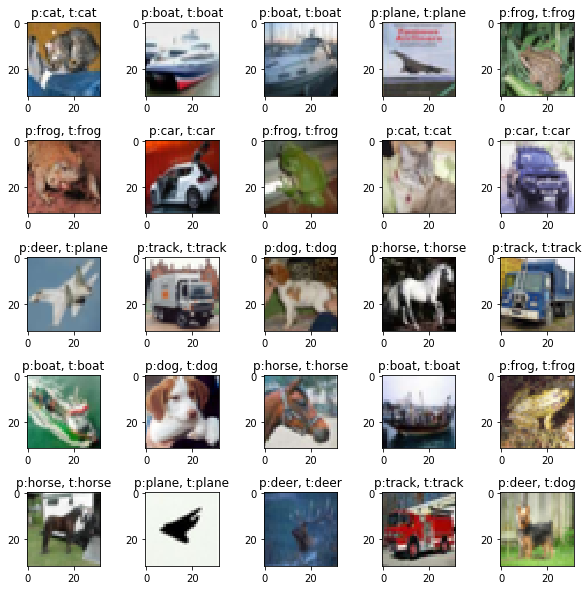

In [19]:
print('x')
print('p: pred_class, t: true_class')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = x_test[i]
    pred_class, pred_per = predict(img, model)
    plt.imshow(img)
    plt.title('p:{0}, t:{1}'.format(label[pred_class],label[int(y_test[i])]))

plt.show()

In [20]:
adv1_test = generate_adv_list(x_test[:max_n], y_test[:max_n], model, 0.01)
adv1_test.shape

(100, 32, 32, 3)

In [21]:
score = model.evaluate(adv1_test, y_test_catego[:max_n], verbose=0)
print('adv1 eps=0.01')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv1 eps=0.01
Test loss : 1.9721180772781373
Test accuracy : 0.41


adv1 eps=0.01
p: pred_class, t: true_class


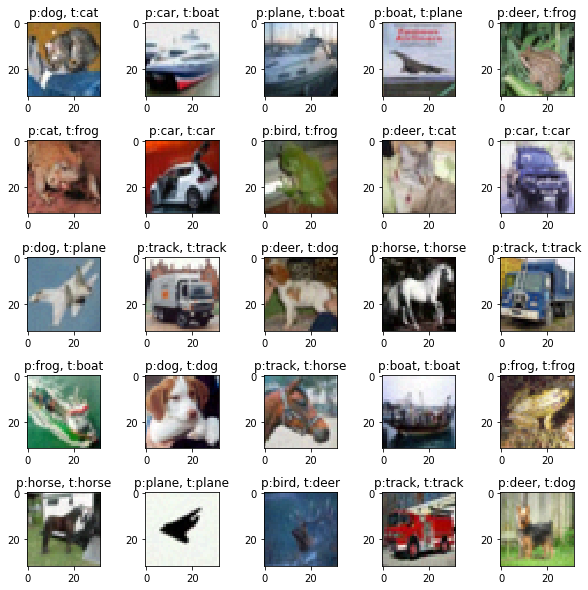

In [22]:
print('adv1 eps=0.01')
print('p: pred_class, t: true_class')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = adv1_test[i]
    pred_class, pred_per = predict(img, model)
    plt.imshow(img)
    plt.title('p:{0}, t:{1}'.format(label[pred_class],label[int(y_test[i])]))

plt.show()

In [23]:
adv2_test = generate_adv_list(x_test[:max_n], y_test[:max_n], model, 0.07)
adv2_test.shape

(100, 32, 32, 3)

In [24]:
score = model.evaluate(adv2_test, y_test_catego[:max_n], verbose=0)
print('adv2 eps=0.07')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv2 eps=0.07
Test loss : 6.00943286895752
Test accuracy : 0.05


adv2 eps=0.07
p: pred_class, t: true_class


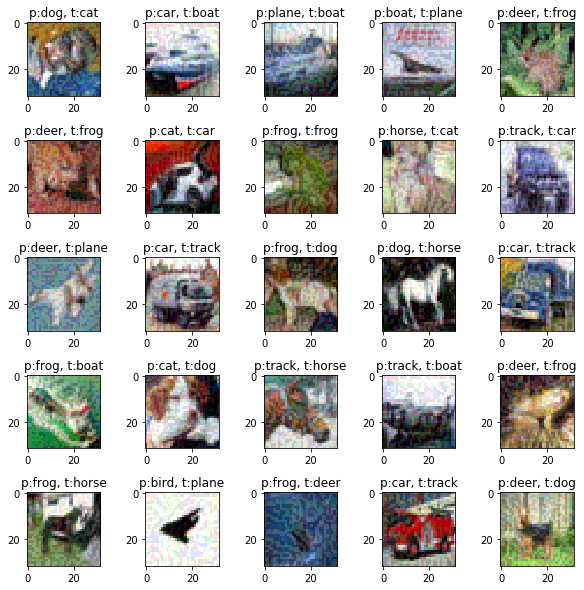

In [25]:
print('adv2 eps=0.07')
print('p: pred_class, t: true_class')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = adv2_test[i]
    pred_class, pred_per = predict(img, model)
    plt.imshow(img)
    plt.title('p:{0}, t:{1}'.format(label[pred_class],label[int(y_test[i])]))

plt.show()